# Example: JUSTICE-MATTER - IAM Simulation Run

#### Imports

In [1]:
import pandas as pd
from emodps.rbf import RBF
import numpy as np
import h5py
import matplotlib.pyplot as plt

from src.util.data_loader import DataLoader
from src.util.enumerations import *
from src.util.model_time import TimeHorizon
from src.util.emission_control_constraint import EmissionControlConstraint
from src.model import JUSTICE
from src.util.enumerations import Economy, DamageFunction, Abatement, WelfareFunction, EconomySubModules


#### Setting Recycling Rate

JUSTICE-MATTER allows for a third policy lever: Recyling Rate. To run the simulation version of the model, we need to feed the policy levers with values we want to test. The ranges of the policy levers are from 0 to 1.0 corresponding to 0% to 100%

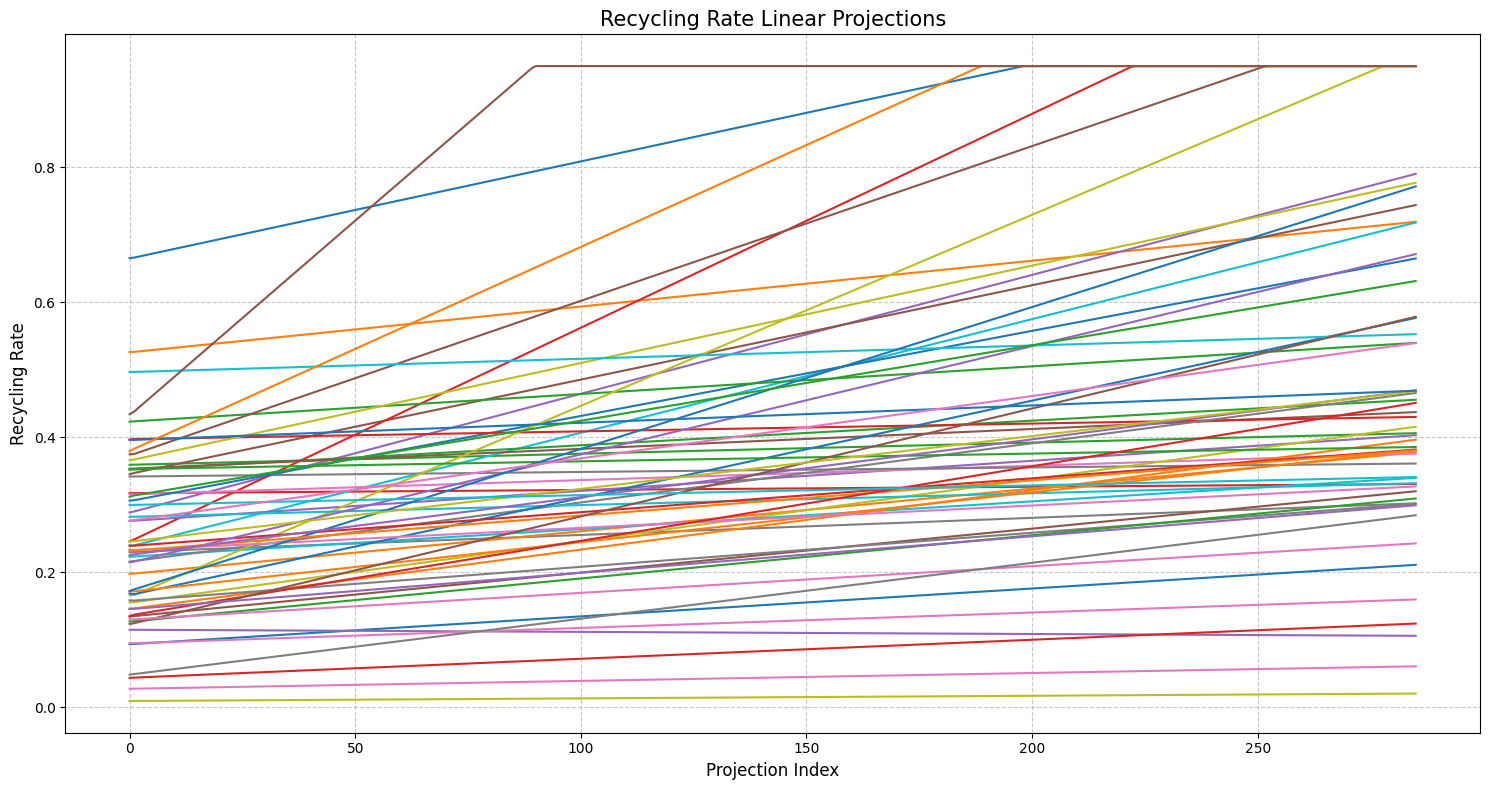

In [2]:
#Load recycling data
data_loader = DataLoader()
recycling_rate = data_loader.RECYCLING_RATE_LINEAR_PROYECTION

# Plotting the linear projections
plt.figure(figsize=(15, 8))
for i in range(recycling_rate.shape[0]):
    plt.plot(recycling_rate[i], label=f'Region {i+1}')
plt.xlabel('Projection Index', fontsize=12)
plt.ylabel('Recycling Rate', fontsize=12)
plt.title('Recycling Rate Linear Projections', fontsize=15)

plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [ ]:
from src.model import JUSTICE
from src.util.enumerations import Economy, DamageFunction, Abatement, WelfareFunction, EconomySubModules

# Instantiate the model
scenarios = 7
time_horizon = TimeHorizon(start_year=2015, end_year=2300, data_timestep=5, timestep=1)
model = JUSTICE(
    scenario=scenarios,
    economy_type=Economy.NEOCLASSICAL,
    damage_function_type=DamageFunction.KALKUHL,
    abatement_type=Abatement.ENERDATA,
    social_welfare_function=WelfareFunction.UTILITARIAN,
    matter=EconomySubModules.MATTER,  # Specify the economy submodule as MATTER
)

for timestep in range(len(time_horizon.model_time_horizon)):
    model.stepwise_run(
        emission_control_rate=emissions_control_rate[:, timestep], 
        timestep=timestep, 
        endogenous_savings_rate=True, 
        recycling_rate=recycling_rate
    )
    datasets = model.stepwise_evaluate(timestep=timestep)

Kalkuhl Damage Function Activated
Enerdata Abatement Model Activated
Neoclassical Economy Model Activated
Matter Model Activated


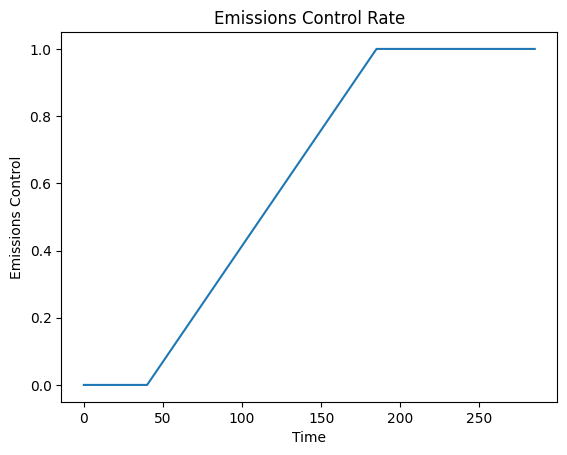

In [3]:
# Load the data
data_loader = DataLoader()

# Instantiate the TimeHorizon class
time_horizon = TimeHorizon(start_year=2015, end_year=2300, data_timestep=5, timestep=1)

#emissions control rate borrowed from emissions module

#Variables to be changed/deleted later
miu_initial = 0.0
min_miu = 0.0 #0.0 #1.0
min_miu_year = 2055 #9-original #8 in this model  # 2060
max_miu = 1.0
max_miu_year = 2200 #38-original #37 in this model #2205

t_min_miu = time_horizon.year_to_timestep(min_miu_year, timestep=1)
t_max_miu = time_horizon.year_to_timestep(max_miu_year, timestep=1)

#Initialize emissions control rate
emissions_control_rate = np.zeros((len(data_loader.REGION_LIST), len(time_horizon.model_time_horizon)))

for t in range(len(time_horizon.model_time_horizon)):
    
    if t < t_min_miu:       # Before time of transition
        emissions_control_rate[:,t] = min_miu
    elif t <= t_max_miu:   # Transition
        # During the transition
        emissions_control_rate[:, t] = min_miu + (max_miu - min_miu) * (t - t_min_miu)/(t_max_miu - t_min_miu)
    else:                   # After the transition
        emissions_control_rate[:, t] = max_miu


from matplotlib import pyplot as plt
plt.plot(emissions_control_rate[0, :])
plt.title("Emissions Control Rate")
plt.xlabel("Time")
plt.ylabel("Emissions Control")
plt.show()

### RUN

#### Linear ECR, Single Scenario

In [4]:
# Get list of Scenarios from Enum

for idx, scenarios in enumerate(list(Scenario.__members__.keys())):
    print(idx, scenarios)

0 SSP119
1 SSP126
2 SSP245
3 SSP370
4 SSP434
5 SSP460
6 SSP534
7 SSP585


In [36]:
from src.model import JUSTICE
from src.util.enumerations import Economy, DamageFunction, Abatement, WelfareFunction, EconomySubModules

# Instantiate the model
scenarios = 7
time_horizon = TimeHorizon(start_year=2015, end_year=2300, data_timestep=5, timestep=1)
model = JUSTICE(
    scenario=scenarios,
    economy_type=Economy.NEOCLASSICAL,
    damage_function_type=DamageFunction.KALKUHL,
    abatement_type=Abatement.ENERDATA,
    social_welfare_function=WelfareFunction.UTILITARIAN,
    matter=EconomySubModules.MATTER,  # Specify the economy submodule as MATTER
)

for timestep in range(len(time_horizon.model_time_horizon)):
    model.stepwise_run(
        emission_control_rate=emissions_control_rate[:, timestep], 
        timestep=timestep, 
        endogenous_savings_rate=True, 
        recycling_rate=recycling_rate
    )
    datasets = model.stepwise_evaluate(timestep=timestep)

Kalkuhl Damage Function Activated
Enerdata Abatement Model Activated
Neoclassical Economy Model Activated
Matter Model Activated


#### Optimized ECR, Single Scenario

In [11]:

def JUSTICE_stepwise_run(
    scenarios=7,
    elasticity_of_marginal_utility_of_consumption=1.45,
    pure_rate_of_social_time_preference=0.015,
    inequality_aversion=0.5,
    path_to_rbf_weights="data/input/optimized_rbf/100049.csv",
    path_to_output="data/output/",
    saving=True,
    output_file_name='bau_matter_SSP585_',
    rbf_policy_index=1033,
    n_inputs_rbf=2,
    max_annual_growth_rate=0.04,
    emission_control_start_timestep=10,
    min_emission_control_rate=0.01,
    allow_emission_fallback=False,  # Default is False
    endogenous_savings_rate=True,
    max_temperature=16.0,
    min_temperature=0.0,
    max_difference=2.0,
    min_difference=0.0,
):
    """
    Run the JUSTICE model for a given scenario
    """
    model = JUSTICE(
        scenario=scenarios,
        economy_type=Economy.NEOCLASSICAL,
        damage_function_type=DamageFunction.KALKUHL,
        abatement_type=Abatement.ENERDATA,
        social_welfare_function=WelfareFunction.UTILITARIAN,
        matter=EconomySubModules.MATTER,
        elasticity_of_marginal_utility_of_consumption=elasticity_of_marginal_utility_of_consumption,
        pure_rate_of_social_time_preference=pure_rate_of_social_time_preference,
        inequality_aversion=inequality_aversion,

    )

    time_horizon = model.__getattribute__("time_horizon")
    data_loader = model.__getattribute__("data_loader")
    no_of_ensembles = model.__getattribute__("no_of_ensembles")
    n_regions = len(data_loader.REGION_LIST)
    n_timesteps = len(time_horizon.model_time_horizon)

    # Setting up the RBF. Note: this depends on the setup of the optimization run
    rbf = setup_RBF_for_emission_control(
        region_list=data_loader.REGION_LIST,
        rbf_policy_index=rbf_policy_index,
        n_inputs_rbf=n_inputs_rbf,
        path_to_rbf_weights=path_to_rbf_weights,
    )
    emission_constraint = EmissionControlConstraint(
        max_annual_growth_rate=max_annual_growth_rate,
        emission_control_start_timestep=emission_control_start_timestep,
        min_emission_control_rate=min_emission_control_rate,
    )

    # Initialize datasets to store the results
    datasets = {}

    # Initialize emissions control rate
    emissions_control_rate = np.zeros((n_regions, n_timesteps, no_of_ensembles))
    constrained_emission_control_rate = np.zeros(
        (n_regions, n_timesteps, no_of_ensembles)
    )


    previous_temperature = 0
    difference = 0
    max_temperature = max_temperature
    min_temperature = min_temperature
    max_difference = max_difference
    min_difference = min_difference

    for timestep in range(n_timesteps):

        # Constrain the emission control rate
        constrained_emission_control_rate[:, timestep, :] = (
            emission_constraint.constrain_emission_control_rate(
                emissions_control_rate[:, timestep, :],
                timestep,
                allow_fallback=allow_emission_fallback,
            )
        )

        model.stepwise_run(
            emission_control_rate=constrained_emission_control_rate[:, timestep, :],
            timestep=timestep,
            endogenous_savings_rate=endogenous_savings_rate,
            recycling_rate=recycling_rate
        )
        datasets = model.stepwise_evaluate(timestep=timestep)
        temperature = datasets["global_temperature"][timestep, :]

        if timestep % 5 == 0:
            difference = temperature - previous_temperature
            # Do something with the difference variable
            previous_temperature = temperature

        # Apply Min Max Scaling to temperature and difference
        scaled_temperature = (temperature - min_temperature) / (
            max_temperature - min_temperature
        )
        scaled_difference = (difference - min_difference) / (
            max_difference - min_difference
        )

        rbf_input = np.array([scaled_temperature, scaled_difference])

        # Check if this is not the last timestep
        if timestep < n_timesteps - 1:
            emissions_control_rate[:, timestep + 1, :] = rbf.apply_rbfs(rbf_input)

    datasets = model.evaluate()
    datasets["constrained_emission_control_rate"] = constrained_emission_control_rate

    # Save the datasets
    if saving:
        if output_file_name is not None:
            np.save(path_to_output + output_file_name + str(rbf_policy_index), datasets)
    # np.save(
    #     "data/output/optimized_emissions_control_rate.npy",
    #     constrained_emission_control_rate,
    # )

    return datasets


def setup_RBF_for_emission_control(
    region_list,
    rbf_policy_index,
    n_inputs_rbf,
    path_to_rbf_weights,
):

    # Read the csv file
    rbf_decision_vars = pd.read_csv(path_to_rbf_weights)

    # select row
    rbf_decision_vars = rbf_decision_vars.iloc[rbf_policy_index, :]

    # Read the columns starting with name 'center'
    center_columns = rbf_decision_vars.filter(regex="center")

    # Read the columns starting with name 'radii'
    radii_columns = rbf_decision_vars.filter(regex="radii")

    # Read the columns starting with name 'weights'
    weights_columns = rbf_decision_vars.filter(regex="weights")

    # Coverting the center columns to a numpy array
    center_columns = center_columns.to_numpy()

    # Coverting the radii columns to a numpy array
    radii_columns = radii_columns.to_numpy()

    # Coverting the weights columns to a numpy array
    weights_columns = weights_columns.to_numpy()

    # centers = n_rbfs x n_inputs # radii = n_rbfs x n_inputs
    # weights = n_outputs x n_rbfs

    n_outputs_rbf = len(region_list)

    rbf = RBF(n_rbfs=(n_inputs_rbf + 2), n_inputs=n_inputs_rbf, n_outputs=n_outputs_rbf)

    # Populating the decision variables
    centers_flat = center_columns.flatten()
    radii_flat = radii_columns.flatten()
    weights_flat = weights_columns.flatten()

    decision_vars = np.concatenate((centers_flat, radii_flat, weights_flat))

    rbf.set_decision_vars(decision_vars)

    return rbf

if __name__ == "__main__":
    #datasets = JUSTICE_run(scenarios=0)
    datasets = JUSTICE_stepwise_run(scenarios=0)
    # Print the keys of the datasets
    print(datasets.keys())


Kalkuhl Damage Function Activated
Enerdata Abatement Model Activated
Neoclassical Economy Model Activated
Matter Model Activated
dict_keys(['gross_economic_output', 'net_economic_output', 'consumption', 'consumption_per_capita', 'emissions', 'emissions_avoided', 'regional_temperature', 'global_temperature', 'damage_fraction', 'depletion_ratio', 'recycled_material', 'material_consumption', 'discarded_material', 'extracted_matter', 'waste', 'material_reserves', 'material_resources', 'recycling_cost', 'economic_damage', 'abatement_cost', 'carbon_price', 'disentangled_utility', 'welfare_regional_temporal', 'welfare_regional', 'welfare_temporal', 'welfare', 'constrained_emission_control_rate'])


## Evaluate

Extracting the data from the outcome dictionary to the different variables

In [37]:
#Load the data
depletion = datasets['depletion_ratio']#(57, 286, 1001)
emissions_avoided =datasets['emissions_avoided']#(57, 286, 1001)
dmc = datasets['material_consumption']#(57, 286, 1001)
recycled = datasets['recycled_material']#(57, 286, 1001)
extracted = datasets['extracted_matter']#(57, 286, 1001)
waste = datasets['waste']#(57, 286, 1001)
discard = datasets['discarded_material']#(57, 286, 1001)
reserves = datasets['material_reserves']#(57, 286, 1001)
resources = datasets['material_resources']#(57, 286, 1001)
r_costs= datasets['recycling_cost']#(57, 286, 1001)

gross_output = datasets['gross_economic_output'] 
net_output = datasets['net_economic_output']
consumption = datasets['consumption'] #(57, 286, 1001)
cpc = datasets['consumption_per_capita'] #(57, 286, 1001)
emis_control = datasets['emissions'] #(57, 286, 1001)
reg_temp = datasets['regional_temperature']
temp = datasets['global_temperature'] # (286, 1001)
damages = datasets['economic_damage'] #(57, 286, 1001)
abatecost = datasets['abatement_cost'] #(57, 286, 1001)
disentangled_utility = datasets['disentangled_utility'] #(57, 286, 1001)
welfare = datasets['welfare'] # (1001,)
welfare_temporal = datasets['welfare_temporal']  # (286, 1001)
welfare_regional = datasets['welfare_regional'] # (57, 1001)
welfare_regional_temporal = datasets['welfare_regional_temporal'] # (57, 286, 1001)


## Visualize

We can visualize the timeseries of the different outcomes that we extracted in the previous step

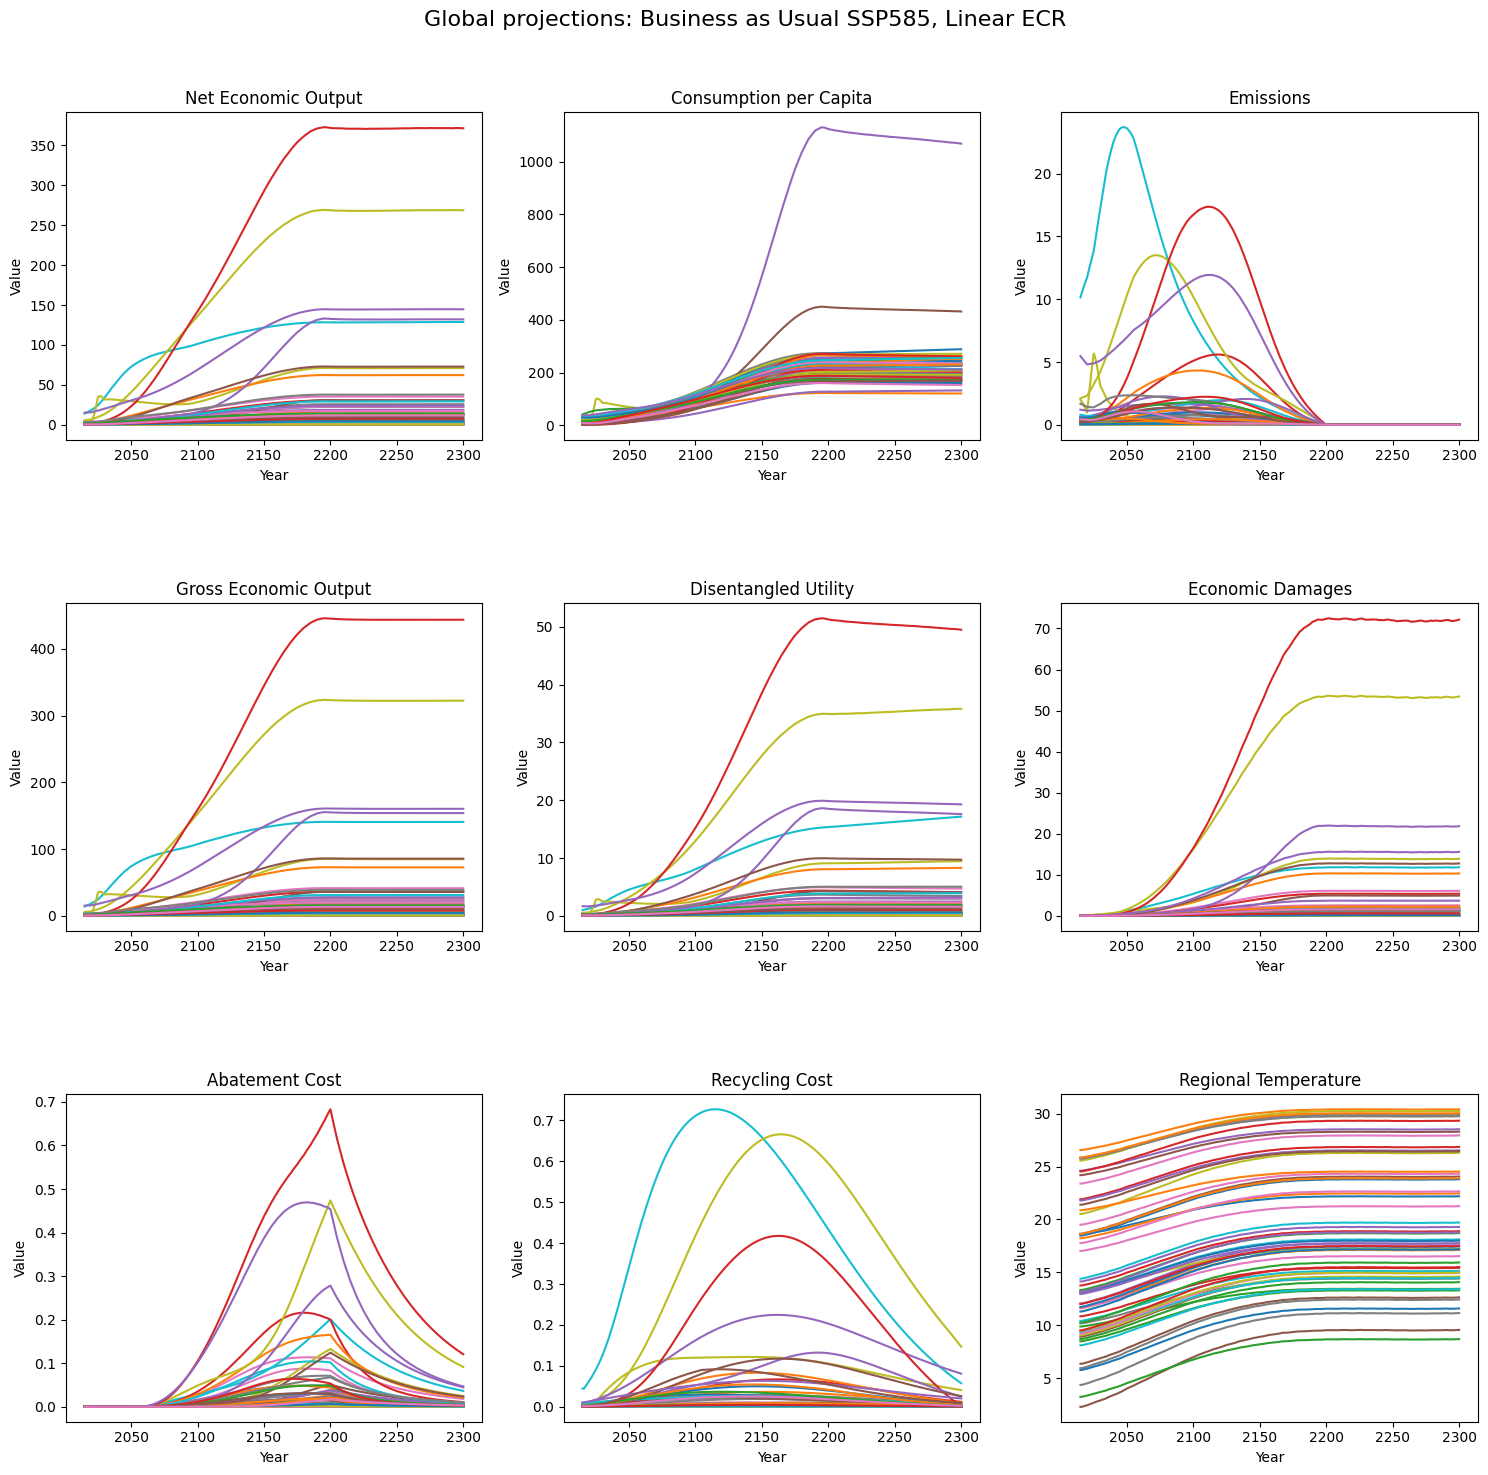

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create list of all the data arrays
data_list = [net_output, cpc, emis_control, gross_output, disentangled_utility, damages, abatecost, r_costs, reg_temp]
titles = ['Net Economic Output', 'Consumption per Capita', 'Emissions', 'Gross Economic Output','Disentangled Utility',
           'Economic Damages', 'Abatement Cost', 'Recycling Cost', 'Regional Temperature']

region_index = 54

# Number of steps to plot
num_steps = 286

# Slice the time horizon to the first 86 steps
time_horizon_sliced = time_horizon.model_time_horizon[:num_steps]


# Create a figure with 2 rows and 3 columns
fig, axs = plt.subplots(3, 3, figsize=(15, 15))
fig.suptitle(
    'Global projections: Business as Usual SSP585, Linear ECR',
      fontsize=16)

# Flatten the axs array to iterate over it
axs = axs.flatten()

# Iterate over the data arrays and plot them
for i, loaded_data in enumerate(data_list):
    # Select the region based on region_index
    data = loaded_data[:, :, :]
    mean_data = np.mean(data, axis=2) # Mean across regions
    
    # Create a line plot for each ensemble
    for j in range(mean_data.shape[0]):
        sns.lineplot(x=time_horizon_sliced, y=mean_data[j,:], ax=axs[i])
    
    # Set the title and axis labels
    axs[i].set_title(titles[i])
    axs[i].set_xlabel('Year')
    axs[i].set_ylabel('Value')

# Remove the unused subplots
for i in range(len(data_list), len(axs)):
    fig.delaxes(axs[i])

# Adjust the layout and spacing
fig.tight_layout(rect=[0, 0, 1, 0.96])
plt.subplots_adjust(hspace=0.5)

plt.show()


Data processing function

In [39]:
import numpy as np
import matplotlib.pyplot as plt

# Load the saved .npy file
output_file_path = "data/output/bau_matter_SSP585_1033.npy"
datasets = np.load(output_file_path, allow_pickle=True).item()


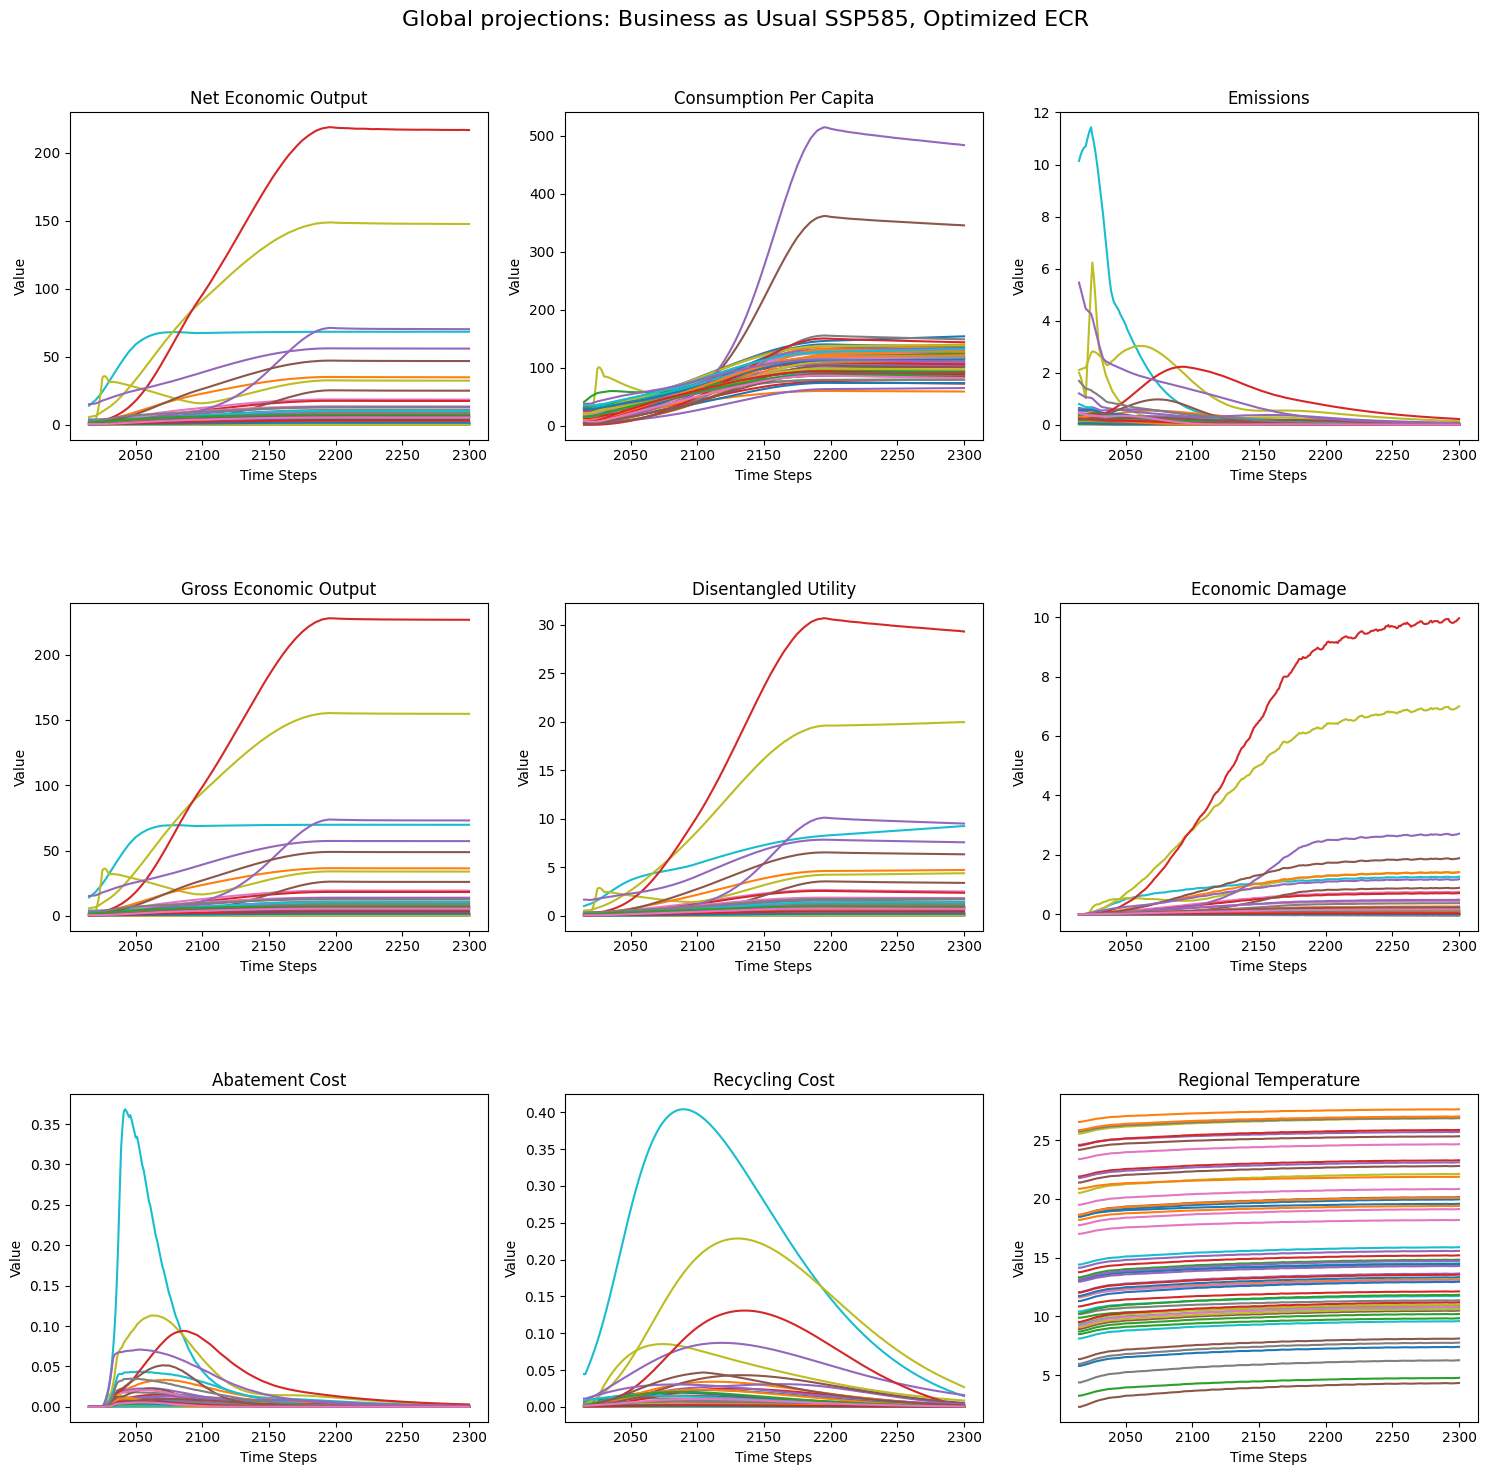

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define the keys in the required order
data_list = [
 'net_economic_output', 'consumption_per_capita', 'emissions',
 'gross_economic_output', 'disentangled_utility','economic_damage',
 'abatement_cost','recycling_cost', 'regional_temperature'
]
years = np.arange(2015, 2301)
# Create a figure with 3 rows and 5 columns
fig, axs = plt.subplots(3, 3, figsize=(15, 15))
fig.suptitle('Global projections: Business as Usual SSP585, Optimized ECR', fontsize=16)

# Flatten the axs array to iterate over it
axs = axs.flatten()

# Plot each variable in a subplot
for i, loaded_data in enumerate(data_list):
    data = datasets.get(loaded_data)
    if data is not None:
        mean_data = np.mean(data, axis=2)  # Mean across regions
        for j in range(mean_data.shape[0]):  # Iterate over ensembles
            sns.lineplot(x=years, y=mean_data[j,:], ax=axs[i])
       
        axs[i].set_title(loaded_data.replace('_', ' ').title())
        axs[i].set_xlabel('Time Steps')
        axs[i].set_ylabel('Value')

# Remove the unused subplots if there are any
for i in range(len(data_list), len(axs)):
    fig.delaxes(axs[i])

# Adjust the layout and spacing
fig.tight_layout(rect=[0, 0, 1, 0.96])
plt.subplots_adjust(hspace=0.5)
plt.show()

## Run all the Scenarios

In [ ]:
from src.model import JUSTICE
from src.util.enumerations import Economy, DamageFunction, Abatement, WelfareFunction, EconomySubModules

# Create a dictionary to store the data for each scenario
scenario_data = {}
time_horizon = TimeHorizon(start_year=2015, end_year=2300, data_timestep=5, timestep=1)

# List of scenarios to run
scenario_list = ['SSP119', 'SSP245', 'SSP370', 'SSP434', 'SSP585']

# Filter scenarios
filtered_scenarios = [s for s in Scenario.__members__.keys() if s in scenario_list]

for idx, scenario_name in enumerate(filtered_scenarios):
    print(idx, scenario_name)
    
    # Initialize the model
    model = JUSTICE(
            scenario=idx,
            economy_type=Economy.NEOCLASSICAL,
            damage_function_type=DamageFunction.KALKUHL,
            abatement_type=Abatement.ENERDATA,
            social_welfare_function=WelfareFunction.UTILITARIAN,
            matter=EconomySubModules.MATTER,
        )
    for timestep in range(len(time_horizon.model_time_horizon)):
        model.stepwise_run(
            emission_control_rate=emissions_control_rate[:, timestep], 
            timestep=timestep, 
            endogenous_savings_rate=True, 
            recycling_rate=recycling_rate
        )
        
        scenario_data[scenario_name] = model.stepwise_evaluate(timestep=timestep)



In [ ]:
#Extract variables of interest
emissions_avoided_data = {}

for scenario_name, data in scenario_data.items():
    # Assuming data["emissions_avoided"] has shape (regions, timesteps, ensembles)
    emissions_avoided = datasets['emissions_avoided']
    emissions_avoided_data[scenario_name] = emissions_avoided

In [ ]:
#Aggregate data for visualization

def aggregate_emissions_avoided(emissions_avoided_data):
    aggregated_data = {}
    for scenario_name, emissions_avoided in emissions_avoided_data.items():
        # Average over regions (axis 0) and ensembles (axis 2)
        mean_values = emissions_avoided.mean(axis=(0, 2))  # Shape: (timesteps,)
        std_dev = emissions_avoided.std(axis=(0, 2))  # Standard deviation for uncertainty
        aggregated_data[scenario_name] = (mean_values, std_dev)
    return aggregated_data
# Example usage:
# emissions_avoided_data = { ... }  # Your loaded data
aggregated_data = aggregate_emissions_avoided(emissions_avoided_data)

## RBF run, with optimized ECR

In [ ]:
# Load the CSV file
rbf_data = pd.read_csv('data/input/optimized_rbf/100049.csv')
# Sort the dataframe by 'welfare_utilitarian' in descending order
sorted_rbf_data = rbf_data.sort_values(by='welfare_utilitarian', ascending=True)
# Select the top row index
top_rbf_policy_index = sorted_rbf_data.index[0]
top_rbf_policy_index

In [ ]:

def JUSTICE_stepwise_run(
    scenarios=2,
    elasticity_of_marginal_utility_of_consumption=1.45,
    pure_rate_of_social_time_preference=0.015,
    inequality_aversion=0.5,
    path_to_rbf_weights="data/input/optimized_rbf/100049.csv",
    path_to_output="data/output/",
    saving=True,
    output_file_name='scenario_2',
    rbf_policy_index=1033,
    n_inputs_rbf=2,
    max_annual_growth_rate=0.04,
    emission_control_start_timestep=10,
    min_emission_control_rate=0.01,
    allow_emission_fallback=False,  # Default is False
    endogenous_savings_rate=True,
    max_temperature=16.0,
    min_temperature=0.0,
    max_difference=2.0,
    min_difference=0.0,
):
    """
    Run the JUSTICE model for a given scenario
    """
    model = JUSTICE(
        scenario=scenarios,
        economy_type=Economy.NEOCLASSICAL,
        damage_function_type=DamageFunction.KALKUHL,
        abatement_type=Abatement.ENERDATA,
        social_welfare_function=WelfareFunction.UTILITARIAN,
        matter=EconomySubModules.MATTER,
        elasticity_of_marginal_utility_of_consumption=elasticity_of_marginal_utility_of_consumption,
        pure_rate_of_social_time_preference=pure_rate_of_social_time_preference,
        inequality_aversion=inequality_aversion,

    )

    time_horizon = model.__getattribute__("time_horizon")
    data_loader = model.__getattribute__("data_loader")
    no_of_ensembles = model.__getattribute__("no_of_ensembles")
    n_regions = len(data_loader.REGION_LIST)
    n_timesteps = len(time_horizon.model_time_horizon)

    # Setting up the RBF. Note: this depends on the setup of the optimization run
    rbf = setup_RBF_for_emission_control(
        region_list=data_loader.REGION_LIST,
        rbf_policy_index=rbf_policy_index,
        n_inputs_rbf=n_inputs_rbf,
        path_to_rbf_weights=path_to_rbf_weights,
    )
    emission_constraint = EmissionControlConstraint(
        max_annual_growth_rate=max_annual_growth_rate,
        emission_control_start_timestep=emission_control_start_timestep,
        min_emission_control_rate=min_emission_control_rate,
    )

    # Initialize datasets to store the results
    datasets = {}

    # Initialize emissions control rate
    emissions_control_rate = np.zeros((n_regions, n_timesteps, no_of_ensembles))
    constrained_emission_control_rate = np.zeros(
        (n_regions, n_timesteps, no_of_ensembles)
    )


    previous_temperature = 0
    difference = 0
    max_temperature = max_temperature
    min_temperature = min_temperature
    max_difference = max_difference
    min_difference = min_difference

    for timestep in range(n_timesteps):

        # Constrain the emission control rate
        constrained_emission_control_rate[:, timestep, :] = (
            emission_constraint.constrain_emission_control_rate(
                emissions_control_rate[:, timestep, :],
                timestep,
                allow_fallback=allow_emission_fallback,
            )
        )

        model.stepwise_run(
            emission_control_rate=constrained_emission_control_rate[:, timestep, :],
            timestep=timestep,
            endogenous_savings_rate=endogenous_savings_rate,
            recycling_rate=recycling_rate
        )
        datasets = model.stepwise_evaluate(timestep=timestep)
        temperature = datasets["global_temperature"][timestep, :]

        if timestep % 5 == 0:
            difference = temperature - previous_temperature
            # Do something with the difference variable
            previous_temperature = temperature

        # Apply Min Max Scaling to temperature and difference
        scaled_temperature = (temperature - min_temperature) / (
            max_temperature - min_temperature
        )
        scaled_difference = (difference - min_difference) / (
            max_difference - min_difference
        )

        rbf_input = np.array([scaled_temperature, scaled_difference])

        # Check if this is not the last timestep
        if timestep < n_timesteps - 1:
            emissions_control_rate[:, timestep + 1, :] = rbf.apply_rbfs(rbf_input)

    datasets = model.evaluate()
    datasets["constrained_emission_control_rate"] = constrained_emission_control_rate

    # Save the datasets
    if saving:
        if output_file_name is not None:
            np.save(path_to_output + output_file_name + str(rbf_policy_index), datasets)
    # np.save(
    #     "data/output/optimized_emissions_control_rate.npy",
    #     constrained_emission_control_rate,
    # )

    return datasets


def setup_RBF_for_emission_control(
    region_list,
    rbf_policy_index,
    n_inputs_rbf,
    path_to_rbf_weights,
):

    # Read the csv file
    rbf_decision_vars = pd.read_csv(path_to_rbf_weights)

    # select row
    rbf_decision_vars = rbf_decision_vars.iloc[rbf_policy_index, :]

    # Read the columns starting with name 'center'
    center_columns = rbf_decision_vars.filter(regex="center")

    # Read the columns starting with name 'radii'
    radii_columns = rbf_decision_vars.filter(regex="radii")

    # Read the columns starting with name 'weights'
    weights_columns = rbf_decision_vars.filter(regex="weights")

    # Coverting the center columns to a numpy array
    center_columns = center_columns.to_numpy()

    # Coverting the radii columns to a numpy array
    radii_columns = radii_columns.to_numpy()

    # Coverting the weights columns to a numpy array
    weights_columns = weights_columns.to_numpy()

    # centers = n_rbfs x n_inputs # radii = n_rbfs x n_inputs
    # weights = n_outputs x n_rbfs

    n_outputs_rbf = len(region_list)

    rbf = RBF(n_rbfs=(n_inputs_rbf + 2), n_inputs=n_inputs_rbf, n_outputs=n_outputs_rbf)

    # Populating the decision variables
    centers_flat = center_columns.flatten()
    radii_flat = radii_columns.flatten()
    weights_flat = weights_columns.flatten()

    decision_vars = np.concatenate((centers_flat, radii_flat, weights_flat))

    rbf.set_decision_vars(decision_vars)

    return rbf


if __name__ == "__main__":
    #datasets = JUSTICE_run(scenarios=0)
    datasets = JUSTICE_stepwise_run(scenarios=0)
    # Print the keys of the datasets
    print(datasets.keys())


In [ ]:
def JUSTICE_stepwise_run(
    scenarios,
    elasticity_of_marginal_utility_of_consumption=1.45,
    pure_rate_of_social_time_preference=0.015,
    inequality_aversion=0.5,
    path_to_rbf_weights="data/input/optimized_rbf/100049.csv",
    path_to_output="data/output/",
    saving=False,
    output_file_name=None,
    rbf_policy_index=1033,
    n_inputs_rbf=2,
    max_annual_growth_rate=0.04,
    emission_control_start_timestep=10,
    min_emission_control_rate=0.01,
    allow_emission_fallback=False,  # Default is False
    endogenous_savings_rate=True,
    max_temperature=16.0,
    min_temperature=0.0,
    max_difference=2.0,
    min_difference=0.0,
):
    """
    Run the JUSTICE model for a given scenario or a list of scenarios.
    """
    scenario_data = {}
    
    for scenario in scenarios:
        model = JUSTICE(
            scenario=scenario,
            economy_type=Economy.NEOCLASSICAL,
            damage_function_type=DamageFunction.KALKUHL,
            abatement_type=Abatement.ENERDATA,
            social_welfare_function=WelfareFunction.UTILITARIAN,
            matter=EconomySubModules.MATTER,
            elasticity_of_marginal_utility_of_consumption=elasticity_of_marginal_utility_of_consumption,
            pure_rate_of_social_time_preference=pure_rate_of_social_time_preference,
            inequality_aversion=inequality_aversion,
        )

        time_horizon = model.__getattribute__("time_horizon")
        data_loader = model.__getattribute__("data_loader")
        no_of_ensembles = model.__getattribute__("no_of_ensembles")
        n_regions = len(data_loader.REGION_LIST)
        n_timesteps = len(time_horizon.model_time_horizon)

        # Setting up the RBF. Note: this depends on the setup of the optimization run
        rbf = setup_RBF_for_emission_control(
            region_list=data_loader.REGION_LIST,
            rbf_policy_index=rbf_policy_index,
            n_inputs_rbf=n_inputs_rbf,
            path_to_rbf_weights=path_to_rbf_weights,
        )
        emission_constraint = EmissionControlConstraint(
            max_annual_growth_rate=max_annual_growth_rate,
            emission_control_start_timestep=emission_control_start_timestep,
            min_emission_control_rate=min_emission_control_rate,
        )

        # Initialize datasets to store the results
        datasets = {}

        # Initialize emissions control rate
        emissions_control_rate = np.zeros((n_regions, n_timesteps, no_of_ensembles))
        constrained_emission_control_rate = np.zeros(
            (n_regions, n_timesteps, no_of_ensembles)
        )

        previous_temperature = 0
        difference = 0

        for timestep in range(n_timesteps):
            # Constrain the emission control rate
            constrained_emission_control_rate[:, timestep, :] = (
                emission_constraint.constrain_emission_control_rate(
                    emissions_control_rate[:, timestep, :],
                    timestep,
                    allow_fallback=allow_emission_fallback,
                )
            )

            model.stepwise_run(
                emission_control_rate=constrained_emission_control_rate[:, timestep, :],
                timestep=timestep,
                endogenous_savings_rate=endogenous_savings_rate,
                recycling_rate=recycling_rate
            )
            datasets = model.stepwise_evaluate(timestep=timestep)
            temperature = datasets["global_temperature"][timestep, :]

            if timestep % 5 == 0:
                difference = temperature - previous_temperature
                # Do something with the difference variable
                previous_temperature = temperature

            # Apply Min Max Scaling to temperature and difference
            scaled_temperature = (temperature - min_temperature) / (
                max_temperature - min_temperature
            )
            scaled_difference = (difference - min_difference) / (
                max_difference - min_difference
            )

            rbf_input = np.array([scaled_temperature, scaled_difference])

            # Check if this is not the last timestep
            if timestep < n_timesteps - 1:
                emissions_control_rate[:, timestep + 1, :] = rbf.apply_rbfs(rbf_input)

        datasets = model.evaluate()
        datasets["constrained_emission_control_rate"] = constrained_emission_control_rate

        # Save the datasets
        if saving:
            if output_file_name is not None:
                np.save(path_to_output + output_file_name + str(rbf_policy_index), datasets)

        scenario_data[scenario] = datasets
        print(f"Completed scenario: {scenario}")

    return scenario_data

def setup_RBF_for_emission_control(
    region_list,
    rbf_policy_index,
    n_inputs_rbf,
    path_to_rbf_weights,
):

    # Read the csv file
    rbf_decision_vars = pd.read_csv(path_to_rbf_weights)

    # select row
    rbf_decision_vars = rbf_decision_vars.iloc[rbf_policy_index, :]

    # Read the columns starting with name 'center'
    center_columns = rbf_decision_vars.filter(regex="center")

    # Read the columns starting with name 'radii'
    radii_columns = rbf_decision_vars.filter(regex="radii")

    # Read the columns starting with name 'weights'
    weights_columns = rbf_decision_vars.filter(regex="weights")

    # Coverting the center columns to a numpy array
    center_columns = center_columns.to_numpy()

    # Coverting the radii columns to a numpy array
    radii_columns = radii_columns.to_numpy()

    # Coverting the weights columns to a numpy array
    weights_columns = weights_columns.to_numpy()

    # centers = n_rbfs x n_inputs # radii = n_rbfs x n_inputs
    # weights = n_outputs x n_rbfs

    n_outputs_rbf = len(region_list)

    rbf = RBF(n_rbfs=(n_inputs_rbf + 2), n_inputs=n_inputs_rbf, n_outputs=n_outputs_rbf)

    # Populating the decision variables
    centers_flat = center_columns.flatten()
    radii_flat = radii_columns.flatten()
    weights_flat = weights_columns.flatten()

    decision_vars = np.concatenate((centers_flat, radii_flat, weights_flat))

    rbf.set_decision_vars(decision_vars)

    return rbf

if __name__ == "__main__":
    # List of scenarios to run
    scenario_list = ['SSP119', 'SSP245', 'SSP370', 'SSP434', 'SSP585']
    filtered_scenarios = [Scenario[s].value[0] for s in scenario_list]

    # Run the JUSTICE model for each scenario
    all_scenario_data = JUSTICE_stepwise_run(
        scenarios=filtered_scenarios,
        elasticity_of_marginal_utility_of_consumption=1.45,
        pure_rate_of_social_time_preference=0.015,
        inequality_aversion=0.5,
        path_to_rbf_weights="data/input/optimized_rbf/100049.csv",
        path_to_output="data/output/",
        saving=True,
        output_file_name="justice_output_",
        rbf_policy_index=1033,
        n_inputs_rbf=2,
        max_annual_growth_rate=0.04,
        emission_control_start_timestep=10,
        min_emission_control_rate=0.01,
        allow_emission_fallback=False,
        endogenous_savings_rate=True,
        max_temperature=16.0,
        min_temperature=0.0,
        max_difference=2.0,
        min_difference=0.0,
    )

    # Print the keys of the datasets for each scenario
    for scenario, datasets in all_scenario_data.items():
        print(f"Scenario: {scenario}")
        print(datasets.keys())
